In [ ]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from Python.tigre.algorithms.single_pass_algorithms import FDK
from Python.tigre.utilities.io.varian.varian_io import ScanParams,ReconParams,read_varian_geometry, load_projections
from Python.tigre.utilities.mask_CBCT import maskCBCT

In [ ]:
mydir = "C:/CBCT_Scatter_Removal_Project/data/clinical/4100758/2021-07-06_101037/11528a87-b894-4239-846d-45d8fd1efeda"

In [ ]:
scan_params = ScanParams(mydir)
recon_params = ReconParams(mydir)
geometry = read_varian_geometry(scan_params,recon_params)

In [ ]:
angular_threshold = scan_params.calculate_angular_threshold()
proj_data = load_projections(mydir, angular_threshold)

In [ ]:
def abs_diff(a,b):
    return np.abs(a-b)

def prct_diff(a,b):
    abs = abs_diff(a,b)
    return 100*abs/(np.abs(a)+1e-6)

In [97]:
recon = np.load('./data/recon_sks2.npy',allow_pickle=True)

In [ ]:
matfile=h5py.File('C:/CBCT_Scatter_Removal_Project/4100758_proj_recon.mat','r')
print(list(matfile.keys()))
matproj = np.array(matfile.get('proj_lg'))
matproj = np.squeeze(matproj)
matproj = np.transpose(matproj,axes=(0,2,1))
matfile.close()

In [ ]:
matrec = FDK(matproj,geometry,np.deg2rad(proj_data.angles),verbose=True
             )

In [ ]:
matrec[matrec<0]=0
recon[recon<0]=0

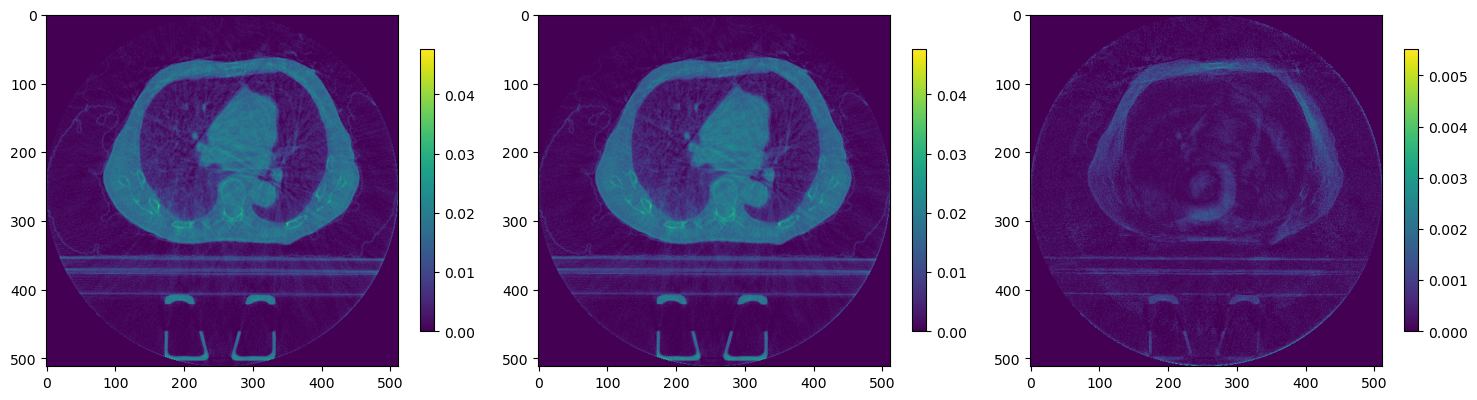

In [105]:
n = 30
r1 = maskCBCT(matrec)[n]
r2 = maskCBCT(recon)[n]
abs = abs_diff(r1,r2)
rmax = np.max([r1,r2])

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(r1.T,vmax=rmax)
plt.colorbar(shrink=0.6)
plt.subplot(132)
plt.imshow(r2.T,vmax=rmax)
plt.colorbar(shrink=0.6)
plt.subplot(133)
plt.imshow(abs.T)
plt.colorbar(shrink=0.6)
plt.tight_layout()
plt.show()

In [ ]:
plt.hist(r1.ravel(),bins=100,alpha=0.4)
plt.hist(r2.ravel(),bins=100,alpha=0.4)
plt.show()

In [ ]:
from numpy.typing import NDArray
from Python.tigre.utilities.io.varian.utils import cm2mm
from Python.tigre.utilities.io.varian.scatter import _get_detector_coords

def calculate_grid_response(u: NDArray, v: NDArray) -> NDArray:
    # TODO: read params from Calibration.xml
    K = -0.15
    K /= cm2mm(1)
    B = 1
    t_ratio = K * abs(v.T) + B
    kernel = np.tile(t_ratio[:, np.newaxis], [1, len(u)])
    kernel[kernel < 0.3] = 0.3
    return kernel

In [107]:
u,v = _get_detector_coords(geometry)

In [ ]:
kernel = calculate_grid_response()